<img style="float: left;" src="D2Klogo.png" width="20%"> 

<center>

# Welcome to DSCI 101 #
### Introduction to Data Science ###

### A Case Study from DSCI 101 Fall 2020 Cohort ###
    
- Contributors: Virginia Baskin, Chloe Chen, Benjamin Meisburger, Prerna Mohan, Dayan Berrones
- Case study notebook developped by Ben Meisburger and Su Chen

<h1><center>Classification and Prediction of Ozone Action Days from Meteorological Data</center></h1>

# Introduction

High levels of ground-level ozone (O3) has adverse effects on crops, trees, vegetation, and, most importantly, human health. When inhaled, ozone, which is an inorganic molecule consisting of three oxygen atoms, can cause damage to the lungs, especially affecting people who suffer from lung conditions like asthma, bronchitis, pneumonia, colds, and notably COVID-19. Even in relatively low concentrations, O3 can be toxic and cause serious irritation. Even worse, long exposure can put an individual at risk of ozone poisoning, lung cancer, lung scarring, and even potentially death. Children are the most vulnerable to ozone, as their lungs are still developing and they are more likely than adults to spend long periods of time outdoors. 

As humanity continues to progress, it becomes increasingly difficult to balance humanity’s ambitions with the well-being of the environment, and even our own subsequent quality of life. We are reminded of our vulnerability to such threats and of the disparity that exists in the degree to which each individual is affected. This increasingly relevant situation motivated us to analyze whether any significant differences existed between the easily observed weather features for ozone and non-ozone days. We then hoped to deduce if it was possible to classify future days as ozone or non-ozone based on the noted differences. 

In [1]:
### Standard imports

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True

#from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
#sns.set_theme()
#sns.color_palette("rocket", as_cmap=True)
#sns.set_context(context='paper')
#sns.set_style('whitegrid')
#sns.set_style('ticks')

import warnings
warnings.filterwarnings("ignore")

# Data and Data Exploration

Only one data set was utilized for this project: the multivariate ground level ozone data set sourced from [the University of California, Irvine, School of Information and Computer Sciences](https://archive.ics.uci.edu/ml/datasets/ozone+level+detection). This data set consists of hourly and daily meteorological observations collected from 1998 to 2004 at the Houston, Galveston, and Brazoria areas. Additionally, each recorded day was labeled as an ozone-action or normal day. Of these approx. 1100 days, only 6.9\% of which were classified as ozone days. Other features include: date of observation, hourly average wind speed, daily peak wind speed, hourly average temperature, daily peak temperature, average daily temperature, sea-level pressure, and precipitation, etc. A full list of variables are described in the Appendix. 

To prepare for exploratory data analysis, daily observations with missing values were removed from the data set. Next, the date variable/strings were decomposed at slash delineators and organized into month, day, and year dummy variables that were added to the original matrix. Feature object types were also unified from strings and integers to float decimal values for easier comparison. 

##  Read data, create dataframes, and clean data

In [2]:
# code missing values correctly
missing_values = ["?", -9]
ozone = pd.read_csv('ozone_raw.csv', na_values=missing_values)

# drop date (for now)
ozone_date = ozone['Date']
ozone_full = ozone.drop(columns=['Date'])

# cast df to floats
ozone_full = ozone_full.astype('float')

# print dataframe shape
print(ozone_full.shape)

# check for missing values:
ozone_full.isna().sum()

# print dataframe shape after drop missing values
print(ozone_full.dropna().shape)

# drop missing values
ozone_full.dropna(inplace=True)

(2534, 73)
(1833, 73)


In [3]:
# take a subset of attributes that we think might be important indicators, including label (ozone day)
ozone_condensed = ozone_full[['T_AV', 'WSR_AV', 'SLP', 'SLP_', 'Precp', 'Ozone Day']]

# rename columns to be informative
ozone_condensed.rename(columns={'T_AV':'average_temperature', 'WSR_AV':'average_wind_speed', 
                                'SLP':'sea_level_pressure', 'SLP_':'sea_level_pressure_change', 
                                'Precp':'precipitation', 'Ozone Day':'ozone_day'}, inplace=True)

#### delete??? never used??? create separate dataframes for ozone and non-ozone days (this will come in handy later)
ozone_days = ozone_condensed[ozone_condensed['ozone_day'] == 1]
nozone_days = ozone_condensed[ozone_condensed['ozone_day'] == 0]

ozone_condensed.head()

average_temperature  average_wind_speed  sea_level_pressure  \
0                 12.5                 3.1             10330.0   
1                 17.8                 3.4             10275.0   
2                 18.7                 3.5             10235.0   
3                 18.7                 3.2             10195.0   
6                  9.7                 5.2             10040.0   

   sea_level_pressure_change  precipitation  ozone_day  
0                      -55.0           0.00        0.0  
1                      -55.0           0.00        0.0  
2                      -40.0           0.00        0.0  
3                      -40.0           2.08        0.0  
6                      -80.0           0.18        0.0

## Data exploration

It is important to note that our data set was very class imbalanced (ozone action vs normal days). As mentioned before, there were only 6.9\% (128) classified ozone days and 93.1\% (1719) non ozone days, which made most steps in the data science pipeline more complex and required us to constantly factor imbalanced frequencies into our decision making, data exploration, and model fitting. 

In [4]:
print('ozone days: ' + str(ozone_days.shape[0]) + ', ' + str(round(100. * ozone_days.shape[0] / ozone_condensed.shape[0], 2)) + '% of total')
print('normal (non-ozone) days: ' + str(nozone_days.shape[0]) + ', ' + str(round(100. * nozone_days.shape[0] / ozone_condensed.shape[0], 2)) + '% of total')

ozone days: 128, 6.98% of total
normal (non-ozone) days: 1705, 93.02% of total


###  Univariate Analysis

To begin the exploratory data analysis, average wind speed, average temperature, and precipitation, were each compared between ozone and non-ozone days using box plots. An insignificant difference was found in median daily average wind speed between ozone and non-ozone days (Figure 1). However, when average temperature was compared between ozone and non-ozone days, ozone days were found to be right-skewed towards warmer temperatures (Figure 2). 

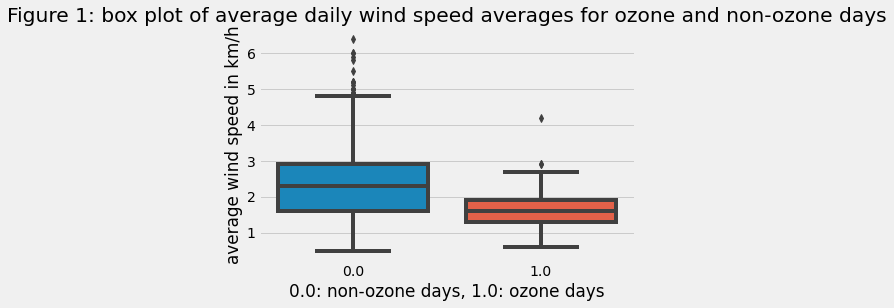

In [5]:
fig1 = sns.boxplot(x='ozone_day', y='average_wind_speed', data=ozone_condensed)
fig1.set_xlabel('0.0: non-ozone days, 1.0: ozone days')
fig1.set_ylabel('average wind speed in km/h')
fig1.set_title('Figure 1: box plot of average daily wind speed averages for ozone and non-ozone days');

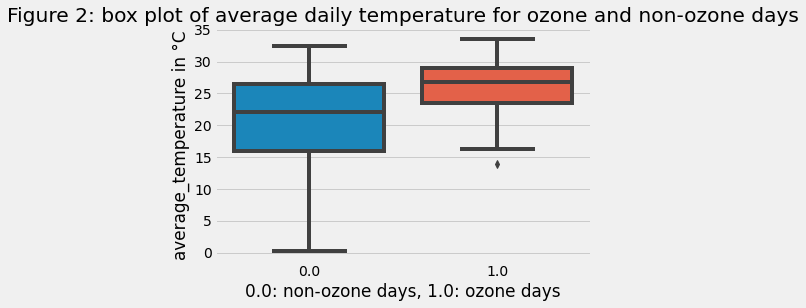

In [6]:
fig2 = sns.boxplot(x='ozone_day', y='average_temperature', data=ozone_condensed)
fig2.set_xlabel('0.0: non-ozone days, 1.0: ozone days')
fig2.set_ylabel('average_temperature in °C')
fig2.set_title('Figure 2: box plot of average daily temperature for ozone and non-ozone days');

### Bivariate Analysis

The relationships between average wind speed, average temperature, sea-level pressure, day-over-day change in sea-level pressure, and precipitation were all compared to one another using bi-variate scatter plots to see if there was any separation between non-ozone and ozone days for the combinations of the above variables (Figure 3). Ozone-action days did display some clustering, especially in the plots comparing average temperature and average wind speed, average temperature and sea-level pressure, and average wind speed and sea-level pressure. 

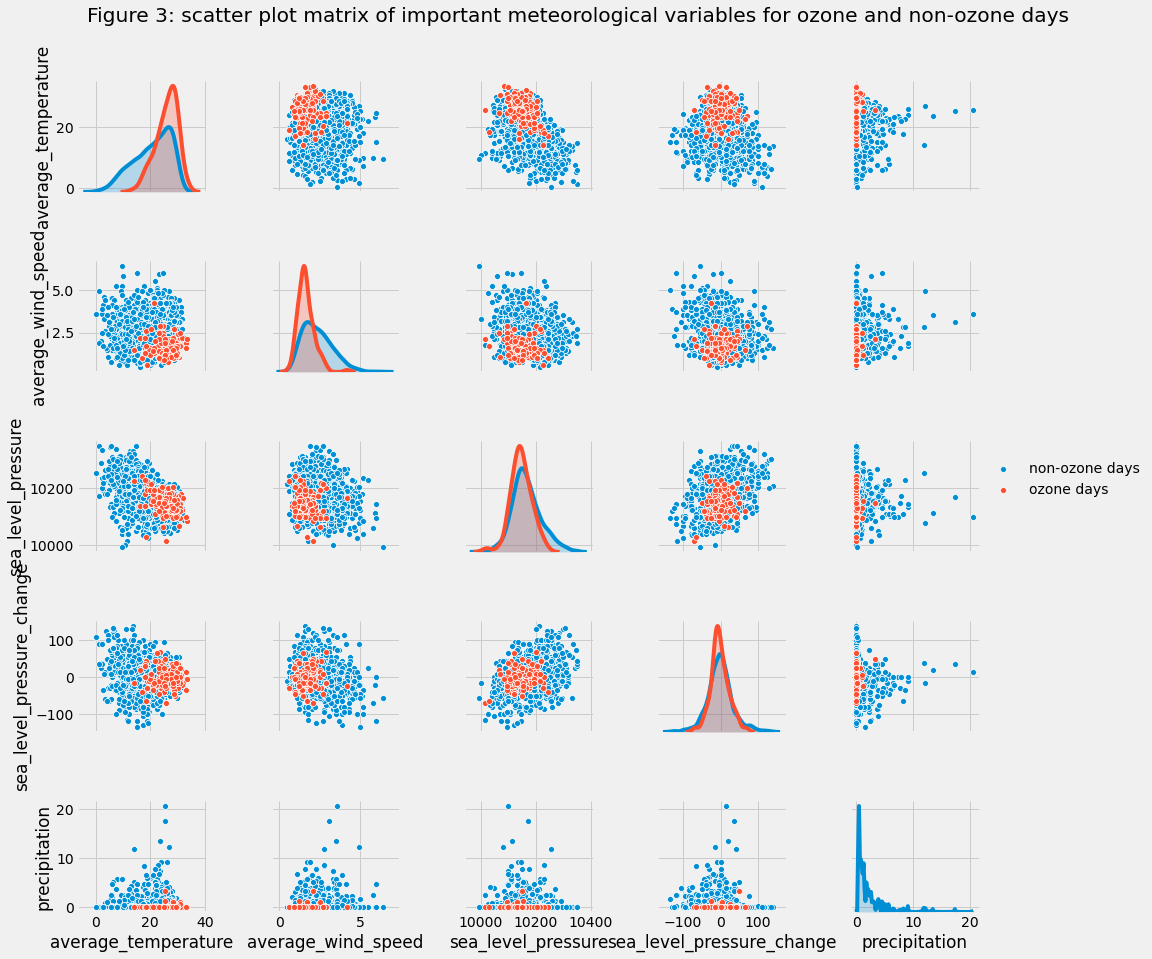

In [7]:
fig3 = sns.pairplot(ozone_condensed, hue="ozone_day")
# remove original legend not informative
fig3._legend.remove()
# add new legend
fig3.add_legend(title='', labels=['non-ozone days', 'ozone days'])
fig3.fig.suptitle('Figure 3: scatter plot matrix of important meteorological variables for ozone and non-ozone days', 
                  fontsize='x-large', y=1.05);

### Multivariate Analysis

Next we perform Principal Component Analysis, an unsupervised learning model for dimensionality deduction. The goal was to reveal further clustering of ozone-action days compared to non-ozone days considering all the meteorological variables in the ozone dataset. To explore the data pattern and clustering of ozone days, we create both 2D and 3D PCA scatter plots using the first 2 and 3 principal components respectively. Notice that the thirst 3 principal components can explain about 94\% of total variation in the data. There was some clustering of ozone-action days which served as a preliminary indication that enough of a difference between ozone-action days and non-ozone days for the following variables can be observed and therefore used in predictive models. 

In [8]:
from sklearn.decomposition import PCA

# separate labels from data
ozone_label = ozone_full['Ozone Day'].replace({0.0: 'non-ozone days', 1.0: 'ozone days'})
ozone_full_feature = ozone_full.drop(columns=['Ozone Day'])

# implement sklearn pca decomposition 
pca = PCA(n_components=10)
ozone_pca = pca.fit_transform(ozone_full_feature)

# percentage of variance explained for each components
print('PCA explained variance ratio: %s'% str(pca.explained_variance_ratio_))
print('First 3 PC explained variance ratio: %.3f' % pca.explained_variance_ratio_[0:3].sum())

PCA explained variance ratio: [0.60553764 0.26354839 0.06639518 0.0245751  0.0172992  0.00536723
 0.00354679 0.0032693  0.00209474 0.00150083]
First 3 PC explained variance ratio: 0.935


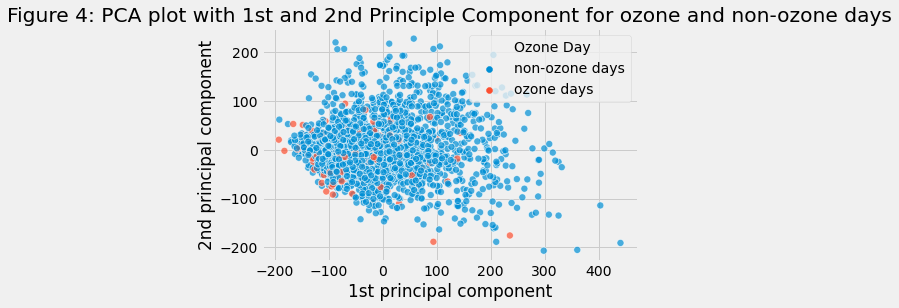

In [9]:
fig4 = sns.scatterplot(x=ozone_pca[:,0], y=ozone_pca[:,1], s=50, alpha=0.7, hue=ozone_label)#, style=ozone_label)
fig4.set_xlabel('1st principal component')
fig4.set_ylabel('2nd principal component')
fig4.set_title('Figure 4: PCA plot with 1st and 2nd Principle Component for ozone and non-ozone days');

In [10]:
# install and import plotly for 3D plot
# %pip install plotly
import plotly.express as px

# create a dataframe for 3D scatter plot so axes will be labeled 
pca_df = pd.DataFrame({'1st principal component':ozone_pca[:,0], '2nd principal component':ozone_pca[:,1],
                       '3nd principal component':ozone_pca[:,2]})

# 3D interactive scatter plot
fig5 = px.scatter_3d(pca_df, x='1st principal component', y='2nd principal component', z='3nd principal component', 
                     color=ozone_label, opacity=0.5,
                     title='Figure 5: PCA plot with 1st, 2nd and 3nd Principle Component for ozone and non-ozone days')
fig5.show()

# Methods and Models

## Hypothesis testing

The first higher-level statistics technique we implemented on our data was hypothesis testing. Our ultimate goal is to predict ozone days accurately given easily-obtained weather factors—inherently, this requires a measurable difference in observations between ozone days and non-ozone days. We decided to examine wind speed averages to evaluate a potential difference between ozone action days and normal weather conditions.

Initially, we compared the average wind speed of ozone days (1.66 $km/h$) to the average wind speed of non-ozone days (2.36 $km/h$). We were optimistic to see such a noticeable difference, but we still had to conduct official hypothesis testing to determine if such a difference was statistically significant. We used A/B testing as our methodology—our null hypothesis was that there is no difference in wind speed average between ozone days and non ozone days; the alternative hypothesis was that there is a difference. 

In [11]:
ozone_wind_speed = ozone_condensed.groupby('ozone_day')[['average_wind_speed']].mean()
ows = ozone_wind_speed.loc[0.0, 'average_wind_speed']
nows = ozone_wind_speed.loc[1.0, 'average_wind_speed']
obs_stat = ows - nows

# define significant level
alpha = 0.05
# initialize empty list to store the simulated statistics
simu_stats = []
# generate 10000 simulated statistics
rep = 10000

for i in np.arange(rep):
    # code to shuffle group labels and calculate the simulated stats
    shuffled_label = np.random.permutation(ozone_condensed['ozone_day'])
    shuffled_df = ozone_condensed[['average_wind_speed']]
    # create a new dataframe with randomly shuffled ozone day labels
    shuffled_df['shuffled_group_label'] = shuffled_label
    group_tb = shuffled_df.groupby(by='shuffled_group_label').mean()
    # find the new defference of average wind speed
    one_simu_stat = group_tb.loc[0.0, 'average_wind_speed'] - group_tb.loc[1.0, 'average_wind_speed']
    simu_stats = np.append(simu_stats, one_simu_stat)
    
#calculate the p-value
p_value = np.average(simu_stats >= obs_stat)
print('Average wind speed (km/h) of ozone days: %.2f'% ows)
print('Average wind speed (km/h) of non-ozone days: %.2f'% nows)  
print('P-value for A/B testing: %.3f'% p_value)

Average wind speed (km/h) of ozone days: 2.37
Average wind speed (km/h) of non-ozone days: 1.66
P-value for A/B testing: 0.000


Continuing our A/B hypothesis testing, we randomly generated ozone action days from our data set and calculated the difference between their average wind speeds and the average wind speeds of non-ozone days. We used a scatter plot to chart this data and found that the simulated differences ranged between $~0.2$ and $~0.2$, if ozone days were random and not dependent on any weather conditions. Our actual observation was $-0.703$; well outside the reasonable range of differences between ozone days and non-ozone days. We calculated an empirical p-value of $0.0$ for this data, which represents the likelihood of our observation being possible assuming the null hypothesis is true. We interpret our p-value to mean that it is practically impossible to observe the difference we saw in our data if ozone days and non ozone days were the same. Therefore, there is a statistically significant difference between the average wind speeds of ozone and non ozone days—confirming, at least partly, the possibility of predicting ozone days from weather observations such as these.

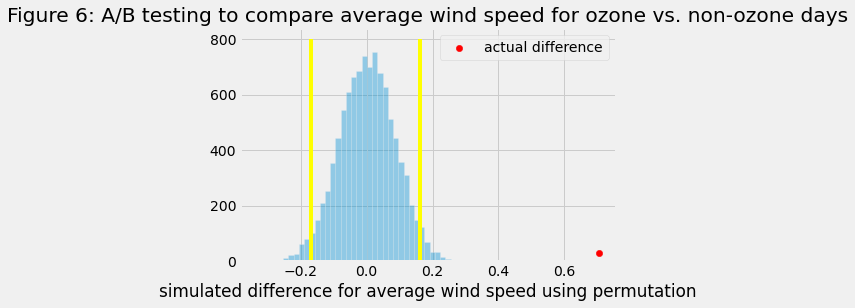

In [12]:
#calculate upper percentile cutoff
cut_off_l = np.percentile(simu_stats, 100*alpha/2)
cut_off_r = np.percentile(simu_stats, 100*(1-alpha/2))
#visualize the simulated statistics list as a histogram
plt.hist(simu_stats, bins=40, alpha=0.4)
#visualize the observed statistic as a red point
plt.scatter(obs_stat, 30, color='red', s=40, label='actual difference')
#visualize the cutoff point as a yellow line
plt.plot([cut_off_l,cut_off_l],[0,800], color='yellow')
plt.plot([cut_off_r,cut_off_r],[0,800], color='yellow')
plt.legend()
plt.xlabel('simulated difference for average wind speed using permutation')
plt.title('Figure 6: A/B testing to compare average wind speed for ozone vs. non-ozone days');

## K-Nearest Neighbor Classifier

To begin our prediction modelling, we constructed a simple $K$ nearest-neighbor classifier, plotting average temperature versus average wind speed. This type of model classifies any future day (a point described by the coordinate pair (`average_temperature`, `average_wind_speed`) by noting where the day lies in relation to a decision boundary. This boundary is created by considering every possible point (`average_temperature`, `average_wind_speed`) within the sample space—the class of the point is determined by taking the majority class of the nearest $K$ observations in the training data set. We experimentally determined that the misclassification error with our testing data was minimized with $K=15$ (approaching an error of approx. $6.5\%$). Our scatter plot and decision boundary map is shown below in Figure 7. Although our misclassification error was low, our data set was unbalanced to begin with, resulting in our KNN classifier performing poorly: **none of the 23 ozone days in the testing data was correctly predicted to be ozone days!**

In [13]:
class_features = ['average_temperature','average_wind_speed']
response = 'ozone_day'
# create featurs matrix and response vector
X = ozone_condensed[class_features]
y = ozone_condensed[response]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
# check the shape of train and test sets
print([X_train.shape, y_train.shape, X_test.shape, y_test.shape])

from sklearn import neighbors

knn_class = neighbors.KNeighborsClassifier(n_neighbors=15)
your_knn_class = knn_class.fit(X_train, y_train)

# make prediction on both training and testing feature matrix
y_train_hat = your_knn_class.predict(X_train)
y_test_hat = your_knn_class.predict(X_test)

from sklearn.metrics import zero_one_loss
print("Training misclassification error:", zero_one_loss(y_train_hat, y_train))
print("Testing misclassification error:", zero_one_loss(y_test_hat, y_test))
print("Number of ozone days in testing data:", sum(y_test==1.0))
print("Corrected predicted ozone day days:", sum((y_test==1) &(y_test_hat==1.0)))

[(1466, 2), (1466,), (367, 2), (367,)]
Training misclassification error: 0.068212824010914
Testing misclassification error: 0.06539509536784738
Number of ozone days in testing data: 23
Corrected predicted ozone day days: 0


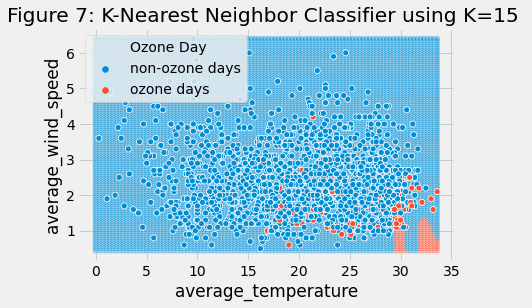

In [19]:
K = 15
knn_class = neighbors.KNeighborsClassifier(n_neighbors=K)
your_knn_class_final = knn_class.fit(X, y)
# plot the decision boundary with original data
step1 = (X.iloc[:,0].max()-X.iloc[:,0].min())/100
step2 = (X.iloc[:,1].max()-X.iloc[:,1].min())/100
x_min, x_max = X.iloc[:,0].min()-step1, X.iloc[:,0].max()+step1
y_min, y_max = X.iloc[:,1].min()-step2, X.iloc[:,1].max()+step2
xx, yy = np.meshgrid(np.arange(x_min, x_max, step1), np.arange(y_min, y_max, step2))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Z = your_knn_class_final.predict(X_grid)

sns.scatterplot(x=X_grid[:,0], y=X_grid[:,1], hue=Z, alpha=0.4, legend=False)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=ozone_label)
plt.title('Figure 7: K-Nearest Neighbor Classifier using K=%i '% K);

## Logistic Regression

Next, we fit a logistic classification model to our data. We used $73$ features for this model, instead of simply average temperature and average wind speed as was the case with KNN classification. Additionally, we used one-hot encoding to add features for the month in which the observation was made (we noticed that ozone-action days occurred in summer months with greater frequency). This method fits a logistic function to the data by minimizing the cross-entropy loss associated with the model. After fitting, this model takes an observation ($73$ variables) as an input and generates a probability between $0$ and $1$ of the observation being either a non-ozone day or ozone action day ($\mathbb{P}>0.5$ is classified as an ozone-action day). We used the option of `class_weight = balanced` option in the logistic regression model to automatically correct the imbalanced classes. This model performed significantly better than our KNN classifier, but had much room for improvement. In the testing data, the logistic regression correctly predicted $20$ out of $23$ ozone-action days, but had a much higher overall misclassification error compared to KNN model. 

In [20]:
# feature engineering
date_exp = ozone_date.str.split(pat='/', expand=True)
# add month as a column
ozone_full['month'] = date_exp[0]

X = ozone_full.drop(columns=['Ozone Day'])
# one-hot-encoding for any categorical predictor
X_dummy = pd.get_dummies(X)
y = ozone_full['Ozone Day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
# check the shape of train and test sets
print([X_train.shape, y_train.shape, X_test.shape, y_test.shape])

[(1466, 73), (1466,), (367, 73), (367,)]


In [21]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(fit_intercept=True, class_weight='balanced')
log_model.fit(X_train, y_train)

# make prediction of both training and testing feature matrix
y_train_hat = log_model.predict(X_train)
y_test_hat = log_model.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix
def confusion(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('Non-Ozone Days Correctly Predicted (True Negatives): ', cm[0][0])
  print('Non-Ozone Days Incorrectly Predicted (False Positives): ', cm[0][1])
  print('Ozone Days Missed (False Negatives): ', cm[1][0])
  print('Ozone Days Correctly Predicted (True Positives): ', cm[1][1])
  print('Total Positive Diagnoses: ', np.sum(cm[1]))
  print('Misclassification rate: ', (np.sum([cm[0][1], cm[1][0]]) / np.sum([cm[0][0], cm[0][1], cm[1][0], cm[1][1]])))

confusion(y_train, y_train_hat)

Non-Ozone Days Correctly Predicted (True Negatives):  1098
Non-Ozone Days Incorrectly Predicted (False Positives):  263
Ozone Days Missed (False Negatives):  12
Ozone Days Correctly Predicted (True Positives):  93
Total Positive Diagnoses:  105
Misclassification rate:  0.18758526603001363


In [264]:
confusion(y_test, y_test_hat)

Non-Ozone Days Correctly Predicted (True Negatives):  267
Non-Ozone Days Incorrectly Predicted (False Positives):  77
Ozone Days Missed (False Negatives):  3
Ozone Days Correctly Predicted (True Positives):  20
Total Positive Diagnoses:  23
Misclassification rate:  0.21798365122615804


## Neural Network Model

Finally, and most successfully, we constructed a simple neural network to classify ozone action days. We began this process by normalizing the distribution of each feature in our data, and then splitting it by ozone and non-ozone day. Next, we fabricated a new, balanced dataset by oversampling from the minority class (ozone action days). This allows us to optimally train the neural network on a normalized, balanced dataset before testing it with the original class distribution. The structure of our neural network consists of five layers of neurons: the input layer ($n=84$ nodes), two densely connected layers ($n=16$ nodes) each with ReLU activation function, a dropout layer, and a single output node. In essence, this model "learns" the patterns of our data and constructs a complicated network of neurons (analogous to organic brain cells) that decides the probability of any given day being an ozone action day. The results of this classification network were promising. It predicted $16$ of $17$ ozone days in our testing data, with only a $6.63\%$ misclassification error—significantly better than both the KNN classifier and logistic regression. Given our severely imbalanced data set, we considered this a success. 

*Code to implement NN model is not included as it is beyond DSCI 101. 

# Results

The results of our investigation are both broad and intersect several stages of the data science pipeline:

## Data Analysis
Both our single variable analysis and hypothesis testing confirms that there is a statistically significant difference between meteorological factors for ozone action days and non-ozone action days. This foreshadows the possibility of classifying/predicting future ozone days purely using easily-obtained observations, regardless of methodology. Next, our bi-variate and tri-variate data analysis reveals a significant level of clustering of ozone action days when plotting two or more features—that is, measurements from ozone action days, such as average temperature and peak wind speed, seem to fall close together. This also suggests that ozone days can be predicted with some reliability.

## Modelling and Prediction
We found that ozone days cannot be accurately predicted with a KNN classification model or multiple-feature logistic regression, primarily due to the imbalance of ozone days vs non ozone days in our dataset. However, they can be classified with modest accuracy using an oversampled neural network. Our neural network classifier correctly predicted $16$ of $17$ ozone action days in our testing data, with only a $6.63\%$ misclassification error. Further, the model had an accuracy of $93.8\%$ (percentage of correct predictions), a recall of $94.1\%$ (percentage of correct ozone-action day predictions), and an AUC of $0.936$ (measure of a model's ability to distinguish between classes—closer to 1 is best). The receiver operating characteristic curve of our model is shown in figure 6—this curve visually illustrates the tradeoff of our model's sensitivity in predicting ozone action days versus percentage of false positive classifications. However, our model's precision was only $42.1\%$ (percentage of correct ozone day predictions). This is certainly due to the imbalance of our dataset (of $~1100$ observations, only $6.93\%$ were ozone action days), and we believe that our model's performance was hindered by the size of our dataset available to train our network. With 2-3x more data, our predictions would be significantly more precise. Even so, we believe that the performance of our classification model is adequate for its intended implementation.

<img style="float: center;" src="ROC.png" width="80%"> 

# Discussion
The results of this project led us to conclude that there were quantifiable and consistent differences between the features for ozone action days versus non-ozone days. Before arriving at this fact, we encountered challenges, such as the imbalanced ozone day percentages hindering our attempt to create a successful logistic regression. At times, the data was too computationally intensive, leading us to reduce the variable amount as well as rethink our method. The primary challenge in the end, was the imbalance in the data, however we overcame that pervasive obstacle by being creative with our sampling techniques. Despite these challenges, we observed that based on the simple weather features of ozone and non-ozone days, one could potentially classify ozone days in the future, without the inherent need for strict human scientific intervention. This is ideal for areas of small populations, where a resident environmental scientist is hard to come by and therefore cannot classify and subsequently warn the people of that area about hazardous ozone days. Instead, our model could give a good guideline for potentially unsafe days. This represents a more accessible way for the classification of ozone days, an implication that would allow us to more effectively protect those at risk from the detrimental health effects occasioned by non-ozone days.


# Appendix

[Data Source](archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection)	

## A complete list of variables
- Feature variables: (all of them are continuous except date)
    - Date: string in mm/dd/yy		
    - WSR0 - WSR23: wind speed measured at every hour of the day
	- WSR_PK: peak wind speed	
    - WSR_AV: average wind speed
    - T0 - T23: temperature at measured every hour of the day
	- T_PK: peak temperature
    - T_AV: average temperature
    - T85/70/50: temperature at 850/700/500 hpa level
    - RH85/70/50: relative Humidity at 50/700/500 hpa	
    - U85/70/50: east-west direction wind at 50/700/500 hpa	
    - V85/70/50: north-south direction wind at 50/700/500	
    - HT85/70/50: geopotential height at 50/700/500 hpa
    - KI: [K-Index](https://en.wikipedia.org/wiki/K-index_(meteorology))
    - TT: [T-Totals](http://tornado.sfsu.edu/geosciences/classes/m201/buoyancy/SkewTMastery/mesoprim/skewt/tt.htm)	
    - SLP: Sea level pressure	
    - SLP_: SLP change from previous day	
    - Precp: precipitation
- Target variable:
    - Ozone Day: binary
        - 0: normal (non-ozone) day
        - 1: ozone day